In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

from pykronecker import KroneckerSum as KS, KroneckerProduct as KP, KroneckerBlockDiag as KBD, KroneckerDiag as KD
from ndgsp.graph.graphs import Graph, ProductGraph

import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import subprocess

import sys
sys.path.append('..')

from utils.plotting import to_colors

2023-03-12 00:32:56.339156: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Using Jax backend with device TFRT_CPU_0


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `coloured_tensor.pdf'.


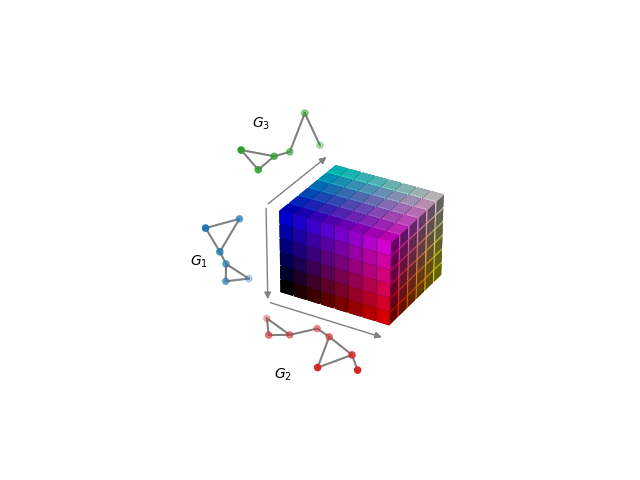

In [2]:
def make_tensor_image_plot():
        
    def get_colors(N1, N2, N3):

        col = np.empty((N1, N2, N3), dtype=object)

        for r in range(N1):
            for g in range(N2):
                for b in range(N3):

                    col[r, g, b] = f'#{int(255 * r / N1):02X}{int(255 * g / N2):02X}{int(255 * b / N3):02X}'

        return col
    
    
    class Arrow3D(FancyArrowPatch):
        
        def __init__(self, xs, ys, zs, *args, **kwargs):
            super().__init__((0,0), (0,0), *args, **kwargs)
            self._verts3d = xs, ys, zs

        def do_3d_projection(self, renderer=None):
            xs3d, ys3d, zs3d = self._verts3d
            xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
            self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

            return np.min(zs)
    
    def explode(data):
        size = np.array(data.shape)*2
        data_e = np.zeros(size - 1, dtype=data.dtype)
        data_e[::2, ::2, ::2] = data
        return data_e

    N1 = 8
    N2 = 6
    N3 = 6

    # build up the numpy logo
    n_voxels = np.zeros((N1, N2, N3), dtype=bool)
    n_voxels[0, 0, :] = True
    n_voxels[-1, 0, :] = True
    n_voxels[1, 0, 2] = True
    n_voxels[2, 0, 1] = True
    facecolors = np.where(n_voxels, '#FFD65DC0', '#7A88CCC0')
    edgecolors = np.where(n_voxels, '#BFAB6E', '#7D84A6')
    filled = np.ones(n_voxels.shape)

    # upscale the above voxel image, leaving gaps
    filled_2 = explode(filled)
    fcolors_2 = explode(facecolors)
    ecolors_2 = explode(edgecolors)

    # Shrink the gaps
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2

    gap = 0.08

    x[0::2, :, :] += gap
    y[:, 0::2, :] += gap
    z[:, :, 0::2] += gap
    x[1::2, :, :] += 1 - gap
    y[:, 1::2, :] += 1 - gap
    z[:, :, 1::2] += 1 - gap

    ax = plt.figure().add_subplot(projection='3d')
    cols = get_colors(2 * N1 - 1, 2 * N2 - 1, 2 * N3 - 1)
    ax.voxels(x, y, z, filled_2, facecolors=cols, edgecolors=cols)


    arrow_prop_dict = dict(mutation_scale=10, arrowstyle='-|>', color='gray')

    a_start = -0.5
    a1 = Arrow3D([a_start, N1], [a_start, a_start], [a_start, a_start], **arrow_prop_dict)
    a2 = Arrow3D([a_start, a_start], [a_start, a_start], [N3 - a_start, a_start], **arrow_prop_dict)
    a3 = Arrow3D([a_start, a_start], [a_start, N2], [N3 - a_start, N3 - a_start], **arrow_prop_dict)

    ax.add_artist(a1)
    ax.add_artist(a2)
    ax.add_artist(a3)

    np.random.seed(0)

    x1 = np.array([np.linspace(0, N1, N1) - 0.8, np.zeros(N1) + 4 * a_start, np.zeros(N1) + 4 * a_start]).T + np.array([np.zeros(N1), np.random.normal(size=N1), np.zeros(N1)]).T

    ax.scatter(x1[:, 0], x1[:, 1], x1[:, 2], color='tab:red')

    for e1, e2 in [[0, 1], [0, 2], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [4, 6]]:

        plt.plot([x1[e1][0], x1[e2][0]], [x1[e1][1], x1[e2][1]], [x1[e1][2], x1[e2][2]], color='gray')


    np.random.seed(1)

    x2 = np.array([np.zeros(N2) + 4 * a_start, np.zeros(N2) + 4 * a_start, 1.5 + np.linspace(0, N2, N2) - 0.8]).T + np.array([np.zeros(N2), np.random.normal(size=N2), np.zeros(N2)]).T

    ax.scatter(x2[:, 0], x2[:, 1], x2[:, 2], color='tab:blue')

    for e1, e2 in [[0, 1], [0, 2], [1, 2], [2, 3], [3, 4], [4, 5], [3, 5]]:

        plt.plot([x2[e1][0], x2[e2][0]], [x2[e1][1], x2[e2][1]], [x2[e1][2], x2[e2][2]], color='gray')


    np.random.seed(1)

    x3 = np.array([np.zeros(N3) + 4 * a_start, np.linspace(0, N3 + 2, N3) - 0.8, N3 + 4.5 + np.zeros(N3) + 4 * a_start]).T + np.array([np.zeros(N2), np.zeros(N2), np.random.normal(size=N2)]).T

    ax.scatter(x3[:, 0], x3[:, 1], x3[:, 2], color='tab:green')

    for e1, e2 in [[0, 1], [0, 2], [1, 2], [2, 3], [3, 4], [4, 5]]:

        plt.plot([x3[e1][0], x3[e2][0]], [x3[e1][1], x3[e2][1]], [x3[e1][2], x3[e2][2]], color='gray')


    ax.text(-1, -1, 12, '$G_3$')
    ax.text(4, -6, -1, '$G_2$')
    ax.text(-1, -7, 6, '$G_1$')

    ax.set_axis_off()
    ax.set_box_aspect([1.3, 1.8, 1.6])

    plt.savefig('coloured_tensor.pdf')

    subprocess.run(['pdfcrop', 'coloured_tensor.pdf', 'coloured_tensor.pdf'])
    
make_tensor_image_plot()

In [109]:
def get_A_from_rules(A_A: np.ndarray, 
                     A_B: np.ndarray, 
                     A_C: np.ndarray, 
                     rules: list[int]):
    """
    Create a Cartesian product graph adjacency matrix using the factor 
    adjacency matrices using the product graph construction rules
    """
    
    A = len(A_A)
    B = len(A_B)
    C = len(A_C)
    
    out = np.zeros((A * B * C, A * B * C))

    nodes = np.argwhere(np.ones((A, B, C)))
    
    for i, (a, b, c) in enumerate(nodes): 
        
        for j, (a_, b_, c_) in enumerate(nodes):
            
            out[i, j] = out[j, i] = (A_A[a, a_] and b == b_ and c == c_) or (a == a_ and A_B[b, b_] and c == c_) or (a == a_ and b == b_ and A_C[c, c_])
            
    return out


def confirm_3d_CPG_form():

    GA = Graph.random_connected(5)
    GB = Graph.random_connected(6)
    GC = Graph.random_connected(7)

    np.allclose(KroneckerSum([GA.A, GB.A, GC.A]).to_array(), get_A_from_rules(GA.A, GB.A, GC.A, [1, 7]))

    return True

In [110]:
confirm_3d_CPG_form()

True

In [14]:
def create_3d_CPG_tex():

    def node (i: int, offset: tuple, colors: tuple):

        return f"""\\node ({i}) at ({offset[0]}, {offset[1]}) {{}};
    \\draw[gray, very thin, fill={{rgb,255: red,{colors[0][0]}; green,{colors[0][1]}; blue,{colors[0][2]}}}, shift={{({offset[0]}, {offset[1]})}}] (0,0) -- (0,0.5) arc[start angle=90, end angle=210, radius=0.5cm] -- (0,0);
    \\draw[gray, very thin, fill={{rgb,255: red,{colors[1][0]}; green,{colors[1][1]}; blue,{colors[1][2]}}}, shift={{({offset[0]}, {offset[1]})}}] (0,0) -- (-0.433,-0.25) arc[start angle=210, end angle=330, radius=0.5cm] -- (0,0);
    \\draw[gray, very thin, fill={{rgb,255: red,{colors[2][0]}; green,{colors[2][1]}; blue,{colors[2][2]}}}, shift={{({offset[0]}, {offset[1]})}}] (0,0) -- (0.433,-0.25) arc[start angle=-30, end angle=90, radius=0.5cm] -- (0,0);

    """

    cA = np.array([(255, 0, 40), (255, 100, 0), (255, 145, 0), (255, 205, 0), (255, 255, 0)])
    cB = np.array([(0, 255, 0), (0, 255, 139), (0, 255, 255), (0, 255, 200)])
    cC = np.array([(0, 0, 255), (140, 0, 255), (200, 0, 255), (255, 0, 255)])

    pA = np.array([(-5.5, 5.75), (-5.5, 2.5), (-4.5, -0.25), (-6.0, -1.75), (-4.75, -4.75)])
    pB = np.array([(-1.25, 2.0), (2.25, 1.75), (7.75, 2.25), (5.0, 0.25)])
    pC = np.array([(11, 1), (14, 4), (17, 1), (14, -2)]).astype(float)

    pA -= np.array(pA).mean(0)
    pB -= np.array(pB).mean(0)
    pC -= np.array(pC).mean(0)

    A_A = np.array([[0, 1, 0, 0, 0], 
                    [1, 0, 1, 1, 0], 
                    [0, 1, 0, 0, 1], 
                    [0, 1, 0, 0, 1], 
                    [0, 0, 1, 1, 0]]).astype(float)

    A_B = np.array([[0, 1, 0, 0], 
                    [1, 0, 1, 1], 
                    [0, 1, 0, 0], 
                    [0, 1, 0, 0]]).astype(float)

    A_C = np.array([[0, 1, 0, 1], 
                    [1, 0, 1, 0], 
                    [0, 1, 0, 1], 
                    [1, 0, 1, 0]]).astype(float)

    A = KroneckerSum([A_A, A_B, A_C]).to_array()


    out = r"""\documentclass[crop,tikz]{standalone}

    \usepackage{tikz}
    \usetikzlibrary{positioning, shapes.geometric, backgrounds}

    \begin{document}

    \begin{tikzpicture}

    """

    for i, (a, b, c) in enumerate(np.argwhere(np.ones((5, 4, 4)))):

        node_tex = node(i, offset=(pA[a] + pB[b] + 4 * pC[c]).round(3), colors=(cA[a], cB[b], cC[c]))

        out += node_tex

    out += r'\begin{scope}[on background layer]'
    out += '\n'

    for i, (a, b, c) in enumerate(np.argwhere(np.ones((5, 4, 4)))):

        for j, (a_, b_, c_) in enumerate(np.argwhere(np.ones((5, 4, 4)))):

            if j < i:
                continue

            if A[i, j]:

                out += f'\draw[gray, very thin] ({i}) to ({j});\n'

    out += r"""

    \end{scope}

    \end{tikzpicture}


    \end{document} """


    with open('diagram.tex', 'w') as f:

        f.write(out)


In [15]:
create_3d_CPG_tex()

In [107]:
def get_k(n: tuple, N: tuple):
    """
    Get the vector index k associated with tensor index n for a tensor of shape N
    """
    d = len(N)
    return int(sum(n[i] * np.prod([N[j] for j in range(i+1, d)]) for i in range(d)))


def get_n(k: int, N: tuple):
    """
    Get the tensor index n associated vector index k with for a tensor of shape N
    """

    d = len(N)
    n = [0] * d

    for i in reversed(range(0, d)):
        n[i] = k % N[i]
        k = k // N[i]

    return tuple(n)


def verify_formulas():

    N = (3, 4, 5)
    Y = np.random.normal(size=N)
    y = Y.reshape(-1)

    k = 15
    n = (1, 2, 3)

    assert y[k] == Y[get_n(k, N)]
    assert Y[n] == y[get_k(n, N)]

    return True

verify_formulas()



True

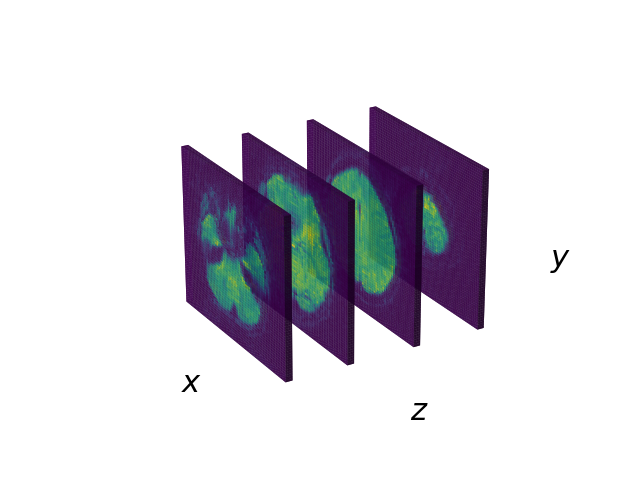

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `fMRI.pdf'.


In [13]:
import matplotlib as mpl
import subprocess
from bids import BIDSLayout



def plot_fMRI():
    
    path = '/media/ed/DATA/Datasets/fMRI/ds001_R2.0.4'
    layout = BIDSLayout(path)
    f = layout.get_file('/media/ed/DATA/Datasets/fMRI/ds001_R2.0.4/sub-01/func/sub-01_task-balloonanalogrisktask_run-01_bold.nii.gz')
    im = f.get_image()
    data = im.get_fdata()

    # prepare some coordinates
    x, y, z = np.indices((64, 30, 64))

    # draw cuboids in the top left and bottom right corners, and a link between
    # them
    cube1 = (y == 0)
    cube2 = (y == 9)
    cube3 = (y == 19)
    cube4 = (y == 29)

    # combine the objects into a single boolean array
    voxelarray = cube1 | cube2 | cube3 | cube4

    # set the colors of each object
    colors = np.empty(voxelarray.shape, dtype=object)
    cols =  to_colors(data[:, :, :, 100], alpha=0.8, vmax=data[:, :, :, 100].max() * 0.8)

    colors[cube1] = cols[:, :, 6].reshape(-1)
    colors[cube2] = cols[:, :, 10].reshape(-1)
    colors[cube3] = cols[:, :, 20].reshape(-1)
    colors[cube4] = cols[:, :, 28].reshape(-1)

    # and plot everything
    ax = plt.figure().add_subplot(projection='3d')

    ax.voxels(voxelarray, facecolors=colors)


    # set x-labels
    ax.set_xlabel('$x$', fontsize=22)
    ax.set_ylabel('$z$', fontsize=22)
    ax.set_zlabel('$y$', fontsize=22)

    # Get rid of the panes
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Get rid of the spines
    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Get rid of the ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])


    ax.set_ylim(0, 30)
    ax.view_init(elev=23.66, azim=-30.77)

    plt.show()

    plt.savefig('fMRI.pdf')

    subprocess.run(['pdfcrop', 'fMRI.pdf', 'fMRI.pdf'])

plot_fMRI()